<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#latest-model-design-&amp;-project-planning" data-toc-modified-id="latest-model-design-&amp;-project-planning-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>latest model design &amp; project planning</a></span></li><li><span><a href="#autophototroph-phenomenological-model" data-toc-modified-id="autophototroph-phenomenological-model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>autophototroph phenomenological model</a></span><ul class="toc-item"><li><span><a href="#functions" data-toc-modified-id="functions-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>functions</a></span></li><li><span><a href="#trial" data-toc-modified-id="trial-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>trial</a></span></li></ul></li><li><span><a href="#heteroorganotroph-phenomenological-model" data-toc-modified-id="heteroorganotroph-phenomenological-model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>heteroorganotroph phenomenological model</a></span><ul class="toc-item"><li><span><a href="#functions" data-toc-modified-id="functions-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>functions</a></span></li><li><span><a href="#trial" data-toc-modified-id="trial-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>trial</a></span></li><li><span><a href="#heteroorganotroph-model-modification-(add-carrying-capacity)" data-toc-modified-id="heteroorganotroph-model-modification-(add-carrying-capacity)-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>heteroorganotroph model modification (add carrying capacity)</a></span></li></ul></li><li><span><a href="#autophototroph-heteroorganotroph-model-coupling" data-toc-modified-id="autophototroph-heteroorganotroph-model-coupling-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>autophototroph-heteroorganotroph model coupling</a></span></li></ul></div>

In [1]:
using RCall, PyCall, Plots, ProgressMeter, DataFrames
mt = pyimport("math")
sc = pyimport("scipy")
cst = pyimport("scipy.constants")
itg = pyimport("scipy.integrate")
R"cbp<-c('#000000', '#E69F00', '#56B4E9', '#009E73', '#0072B2', '#D55E00', '#CC79A7', '#e79f00', '#9ad0f3', '#F0E442', '#999999', '#cccccc', '#6633ff', '#00FFCC', '#0066cc')"
println()

# latest model design & project planning
1. autophototroph phenomenological model (García-Carreras, B. et al. Role of carbon allocation efficiency in the temperature dependence of autotroph growth rates. Proc. Natl. Acad. Sci. 115, E7361–E7368 (2018).)
2. microbial predator phenomenological model (Marsland, R. et al. Available energy fluxes drive a transition in the diversity, stability, and functional structure of microbial communities. PLoS Comput. Biol. 15, e1006793 (2019).)
3. couple models (1) & (2)
4. optimize parameters, give biological meaning (spirulina + commensal bacteria + predatory bacteria / virus)
5. attempt to add in detritivores (E. coli) $\rightarrow$ electricity + carbon sequestration

# autophototroph phenomenological model
## functions

In [2]:
function expFunc(k, A0, T0, E1, T1)
    A = A0 *mt.exp(E1/k*(1/T1-1/T0))
    return (A)
end

expFunc (generic function with 1 method)

In [3]:
function metabolic(k, B0, T0, Ea, T, Ed, Th)
    # give general inputs for parameters (Pg, RL, RD)
    B = expFunc(k, B0, T0, -Ea, T)/(1 + expFunc(k, B0, T, Ed, Th)/B0)
    return (B)
end

metabolic (generic function with 1 method)

In [4]:
function autotroph(pops, t, S, ks, T0C, TC, eps, Pgs, RLs, RDs)
    ## hourly model
    ## input data in unit "day" and "degree Celcius"
    ## eps: [e0, Ee]
    ## Pgs: [P0, Ea, Ed, Th]
    ## RLs: [RL0, Ea, Ed, Th]
    ## RDs: [RD0, Ea, Ed, Th]
    
    N = pops[:1]
    T0 = T0C + 273.15 # reference temperature in Kelvin
    T = TC + 273.15 # test temperature in Kelvin
    k = cst.k * 6.24150934 * 10^18 ## J/K -> eV/K Boltzmann constant
    
    Vn = S/(S+ks)
    ep = expFunc(k, eps[:1], T0, -eps[:2], T) # efficiency
    Pg = metabolic(k, Pgs[:1]*24, T0, Pgs[:2], T, Pgs[:3], Pgs[:4] + 273.15) # max gross photosynthesis rate
    RL = metabolic(k, RLs[:1]*24, T0, RLs[:2], T, RLs[:3], RLs[:4] + 273.15) # daytime respiration rate
    RD = metabolic(k, RDs[:1]*24, T0, RDs[:2], T, RDs[:3], RDs[:4] + 273.15) # night-time respiration rate
    Fc = Pg-RL-RD # net carbon flux
    
    gRt = N*Vn*ep*Fc # gRt = N* rpu: rate per unit
    cue = 1-RL/Pg # cue: carbon use efficiency
    return ([gRt, cue])
end

autotroph (generic function with 1 method)

## trial

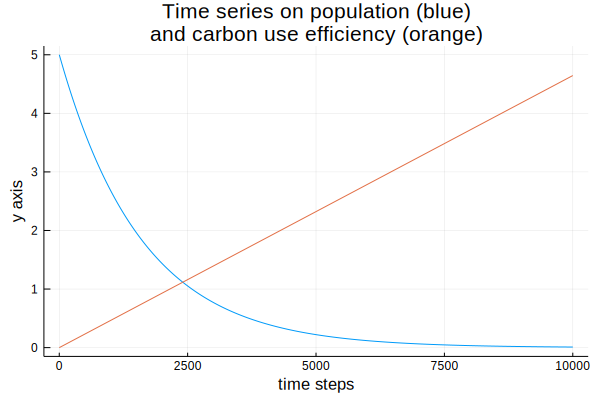

In [5]:
t = sc.linspace(0, 24, 10000) # time series (hours)
pops = sc.array([5,0]) # initial population p, q

## parameters
S = .1 # random (rnd)
ks = .291
T0C = 20 # rnd
TC = 30 # random
eps = sc.array([.068,.636])
Pgs = sc.array([.31,.64,.78,35]) # [rnd, paper, rnd, rnd]
RLs = sc.array([.25,.64,.78,35]) # [rnd, paper, rnd, rnd]
RDs = sc.array([.25,.64,.78,35]) # [rnd, paper, rnd, rnd]

pops, infodict = itg.odeint(autotroph, pops, t, full_output=true, args=(S, ks, T0C, TC, eps, Pgs, RLs, RDs))
plot(pops, xlabel="time steps", ylabel="y axis", title="Time series on population (blue)\nand carbon use efficiency (orange)", label="")

# heteroorganotroph phenomenological model
## functions

In [6]:
function sma(prefA, concA, K, forgTag)
    x = prefA * concA
    
    if forgTag==1
        sigmaVal = x
    else # set type 2 as 1, n = forgTag -1
        sigmaVal = x^(forgTag-1)/(1+(x/K)^(forgTag-1))
    end
        
    return (sigmaVal)
end

sma (generic function with 1 method)

In [7]:
function heterotroph(pops, t, spD, resD)
    # spD = [net gRate, maintenance energy flux, forage type, resAPreference]
    # resD = [EnergyDenA, leakFracA, net gRateA, KA]
    N = pops[:1]
    R = pops[:2]
    
    dNdt = (1 +spD[:1]) * N * ((1-resD[:2]) * resD[:1] * sma(spD[:4], R, resD[:4], spD[:3]) -spD[:2])
    dRdt = (1 +resD[:3]) * R * (resD[:4] -R) # no minus terms `.`only one consumer is involved; self-renewing food source
    
    return ([dNdt, dRdt])
end

heterotroph (generic function with 1 method)

## trial

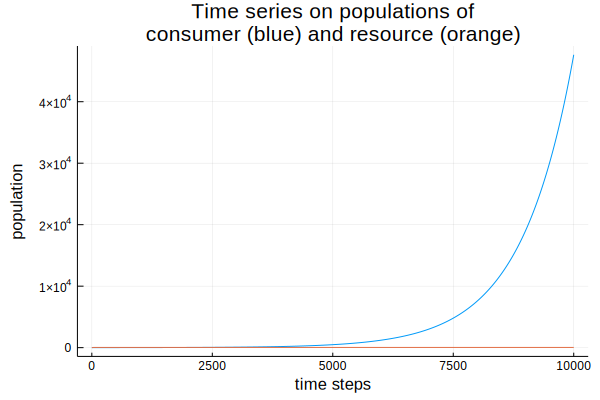

In [8]:
t = sc.linspace(0, 24, 10000) # time series (hours)
pops = sc.array([5,5]) # initial population consumer, resource

spDetails = sc.array([.04,3,2,30])
resDetails = sc.array([.29,.7,.05,40])

pops, infodict = itg.odeint(heterotroph, pops, t, full_output=true, args=(spDetails, resDetails))
plot(pops, xlabel="time steps", ylabel="population", title="Time series on populations of\nconsumer (blue) and resource (orange)", label="")

the above model do not have a carrying capacity?!

## heteroorganotroph model modification (add carrying capacity)

In [11]:
function heterotroph_mod(pops, t, spD, resD)
    # spD = [net gRate, maintenance energy flux, forage type, resAPreference, K]
    # resD = [EnergyDenA, leakFracA, net gRateA, KA]
    N = pops[:1]
    R = pops[:2]
    
    dNdt = N * ( (1 +spD[:1]) * (1-resD[:2]) * resD[:1] * sma(spD[:4], R, resD[:4], spD[:3]) - spD[:2])
    dRdt = (1 +resD[:3]) * R * (resD[:4] - R) - # no minus terms `.`only one consumer is involved; self-renewing food source
    
    return ([dNdt, dRdt])
end

heterotroph_mod (generic function with 1 method)

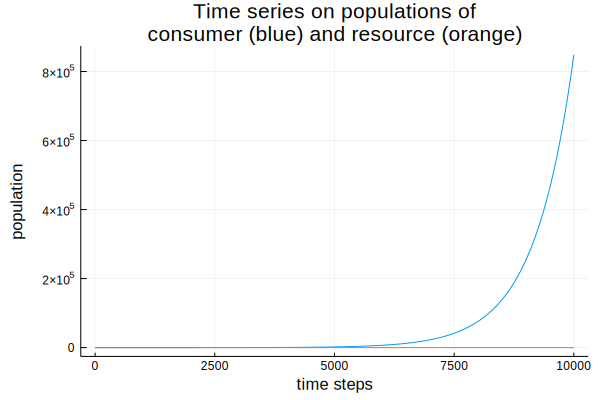

In [12]:
t = sc.linspace(0, 24, 10000) # time series (hours)
pops = sc.array([5,5]) # initial population consumer, resource

spDetails = sc.array([.04,3,2,30, 50])
resDetails = sc.array([.29,.7,.05,40])

pops, infodict = itg.odeint(heterotroph_mod, pops, t, full_output=true, args=(spDetails, resDetails))
plot(pops, xlabel="time steps", ylabel="population", title="Time series on populations of\nconsumer (blue) and resource (orange)", label="")

# autophototroph-heteroorganotroph model coupling